In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ice Concentration repository
Ice_rep  = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V4/north/daily/"
## over 2022 sample period (09/01/2023-12/31/2022)
Ice_files2022 = sorted(os.listdir(path=Ice_rep+"2022/"))[243:]#
## over 2023 sample period (01/01/2023-01/31/2023)
Ice_files2023 = sorted(os.listdir(path=Ice_rep+"2023/"))[:31]#
print(len(Ice_files2022),len(Ice_files2023))

122 31


In [4]:
len(Ice_files2022)

122

In [32]:
ice_files = [f'{Ice_rep}2022/{icef}' for icef in Ice_files2022]
import pprint as pprint
#pprint.pprint(ice_files)

In [6]:
xr.open_dataset(Ice_rep+"2022/"+Ice_files2022[0])

<xarray.Dataset>
Dimensions:                         (tdim: 1, y: 448, x: 304)
Coordinates:
    time                            (tdim) datetime64[ns] ...
    xgrid                           (x) float32 ...
    ygrid                           (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc                 (tdim, y, x) float32 ...
    melt_onset_day_cdr_seaice_conc  (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc            (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc            (tdim, y, x) float32 ...
    projection                      |S1 ...
    qa_of_cdr_seaice_conc           (tdim, y, x) float32 ...
    spatial_interpolation_flag      (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc        (tdim, y, x) float32 ...
    temporal_interpolation_flag     (tdim, y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    source:                    Generated from NSIDC0001
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-02-22T23:11:04Z
    time_coverage_start:       2022-09-01T00:00:00Z
    time_coverage_end:         2022-09-01T23:59:59Z

In [7]:
ice_data = xr.open_mfdataset(ice_files,concat_dim='tdim',  combine='nested')

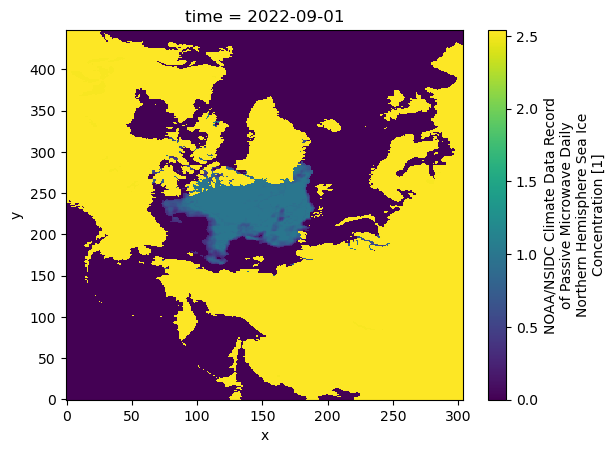

In [8]:
ice_data.cdr_seaice_conc[0].plot()

In [11]:
ice_cdf = ice_data.cdr_seaice_conc.load()

In [12]:
import tqdm as tqdm

In [13]:
first_ice = np.zeros([448,304])
for yi in tqdm.tqdm(range(448)):
    for xi in range(304):
        cv = ice_cdf[:,yi,xi]
        cvf = np.where(cv > 0)[0]
        if len(cvf)> 0:
            first_ice[yi,xi] = cvf[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:21<00:00, 20.63it/s]


In [14]:
first_ice_10p = np.zeros([448,304])
first_ice_20p = np.zeros([448,304])
first_ice_30p = np.zeros([448,304])

for yi in tqdm.tqdm(range(448)):
    for xi in range(304):
        cv = ice_cdf[:,yi,xi]

        cvf = np.where(cv > 0.1)[0]
        if len(cvf)> 0:
            first_ice_10p[yi,xi] = cvf[0]

            cvf = np.where(cv > 0.2)[0]
        if len(cvf)> 0:
            first_ice_20p[yi,xi] = cvf[0]

            cvf = np.where(cv > 0.3)[0]
        if len(cvf)> 0:
            first_ice_30p[yi,xi] = cvf[0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:33<00:00, 13.26it/s]


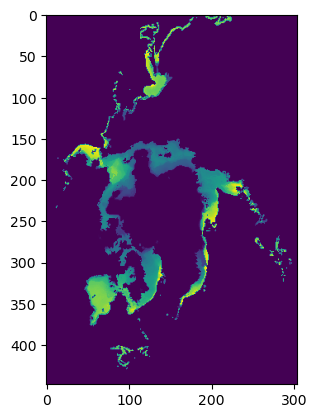

In [15]:
plt.imshow(first_ice)

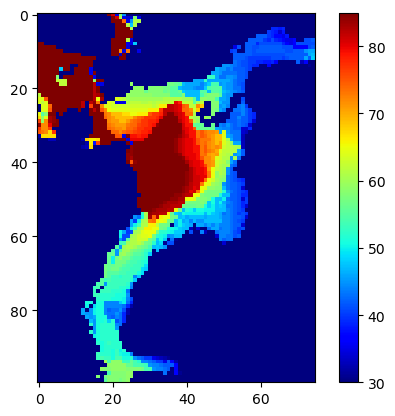

In [16]:
plt.imshow(first_ice[150:250,50:125],vmin=30, vmax=85, cmap='jet');plt.colorbar()

In [17]:
#-------------------------------------------------------------------------------------------------------|
## SASSIE final data collected files directory ---------------------------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'#------------|
## Data files directory --------------------------------------------------------------------------------|
CastAway_CTD    = 'CastAway_CTD/'#----------------------------------------------------------------------|
#-------------------------------------------------------------------------------------------------------|
## Cast away CTD data list
CastAway_CTD_content = os.listdir(Final_SASSIE+CastAway_CTD)
CastAway_CTD_content

CTD_cast = xr.open_dataset(Final_SASSIE+CastAway_CTD+CastAway_CTD_content[0])
CTD_cast

#### Extraction of profiles positions

# longitude & latitude 
ctd_lon = np.array(CTD_cast.longitude)
ctd_lat = np.array(CTD_cast.latitude)

In [18]:
lon0=-150
lonmapmin=-160
lonmapmax=-140
latmapmin=69
latmapmax=75

In [19]:
ice_cdf_x = ice_cdf.xgrid
ice_cdf_y = ice_cdf.ygrid

In [31]:
#ice_cdf

In [21]:
crs_iced = ccrs.epsg(3411)

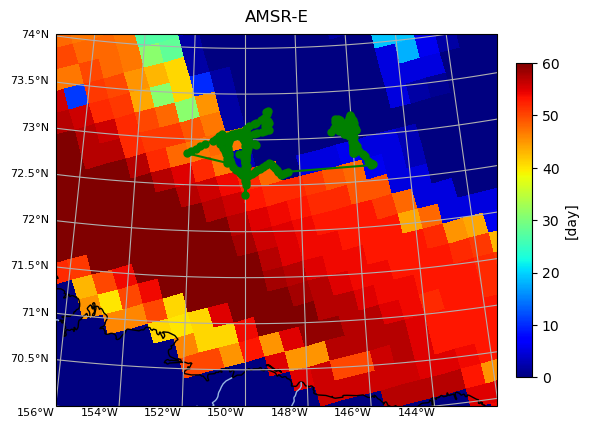

In [22]:
# Figure
fig = plt.figure(figsize=[18, 10])
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=lon0))
fig.subplots_adjust(top=0.9,bottom=0.25,hspace=0.45, left=0.05, right=0.95)
#fig.subplots_adjust(bottom=0.05, top=0.95,left=0.04, right=0.95, wspace=0.02)
ax1.set_extent([-156, -142, 70, 74], crs=ccrs.PlateCarree())#[-180, 180, -90, -60]
#----------------------------------------------------------------------------#
ax1.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
ax1.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
#ax1.add_feature(cfeature.OCEAN)
ax1.coastlines('10m',zorder=2)
g1 = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False)
g1.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
g1.xformatter = LONGITUDE_FORMATTER
g1.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
g1.yformatter = LATITUDE_FORMATTER
g1.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
g1.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
g1.top_labels = False
g1.right_labels = False
##---------------------------------------------------------------------------|
# Even bounds give a contour-like effect:------------------------------------|
bounds = np.linspace(10, 100, 28)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
##---------------------------------------------------------------------------|
ax1.set_title('AMSR-E')
#----------------------------------------------------------------------------#
cb = ax1.pcolormesh(ice_cdf_x,ice_cdf_y,first_ice,transform=crs_iced,
                    cmap='jet', zorder=1, vmin=0,vmax=60)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[day]", orientation="vertical",shrink=0.75)
ax1.plot(ctd_lon, ctd_lat, transform=ccrs.PlateCarree(), zorder=4,marker='.', markersize=10,color='g')

In [23]:
def make_fancy(ax1):
    fig.subplots_adjust(top=0.9,bottom=0.25,hspace=0.45, left=0.05, right=0.95)
    ax1.set_extent([-152, -145, 72, 73.5], crs=ccrs.PlateCarree())#[-180, 180, -90, -60]
    ax1.set_extent([-156, -140, 70, 75], crs=ccrs.PlateCarree())#[-180, 180, -90, -60]    
    g1 = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False)

    #----------------------------------------------------------------------------#
    ax1.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax1.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    #ax1.add_feature(cfeature.OCEAN)
    ax1.coastlines('10m',zorder=2)
    g1.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
    g1.xformatter = LONGITUDE_FORMATTER
    g1.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
    g1.yformatter = LATITUDE_FORMATTER
    g1.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
    g1.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
    g1.top_labels = False
    g1.right_labels = False

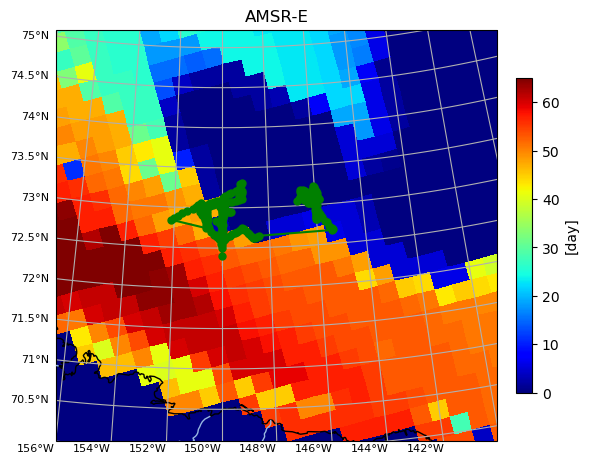

In [24]:
# Figure
fig = plt.figure(figsize=[18, 10])
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=lon0))

make_fancy(ax1)
ax1.set_title('AMSR-E')
#----------------------------------------------------------------------------#
cb = ax1.pcolormesh(ice_cdf_x,ice_cdf_y,first_ice,transform=crs_iced,
                    cmap='jet', zorder=1, vmin=0,vmax=65)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[day]", orientation="vertical",shrink=0.75)
ax1.plot(ctd_lon, ctd_lat, transform=ccrs.PlateCarree(), zorder=4,marker='.', markersize=10,color='g')

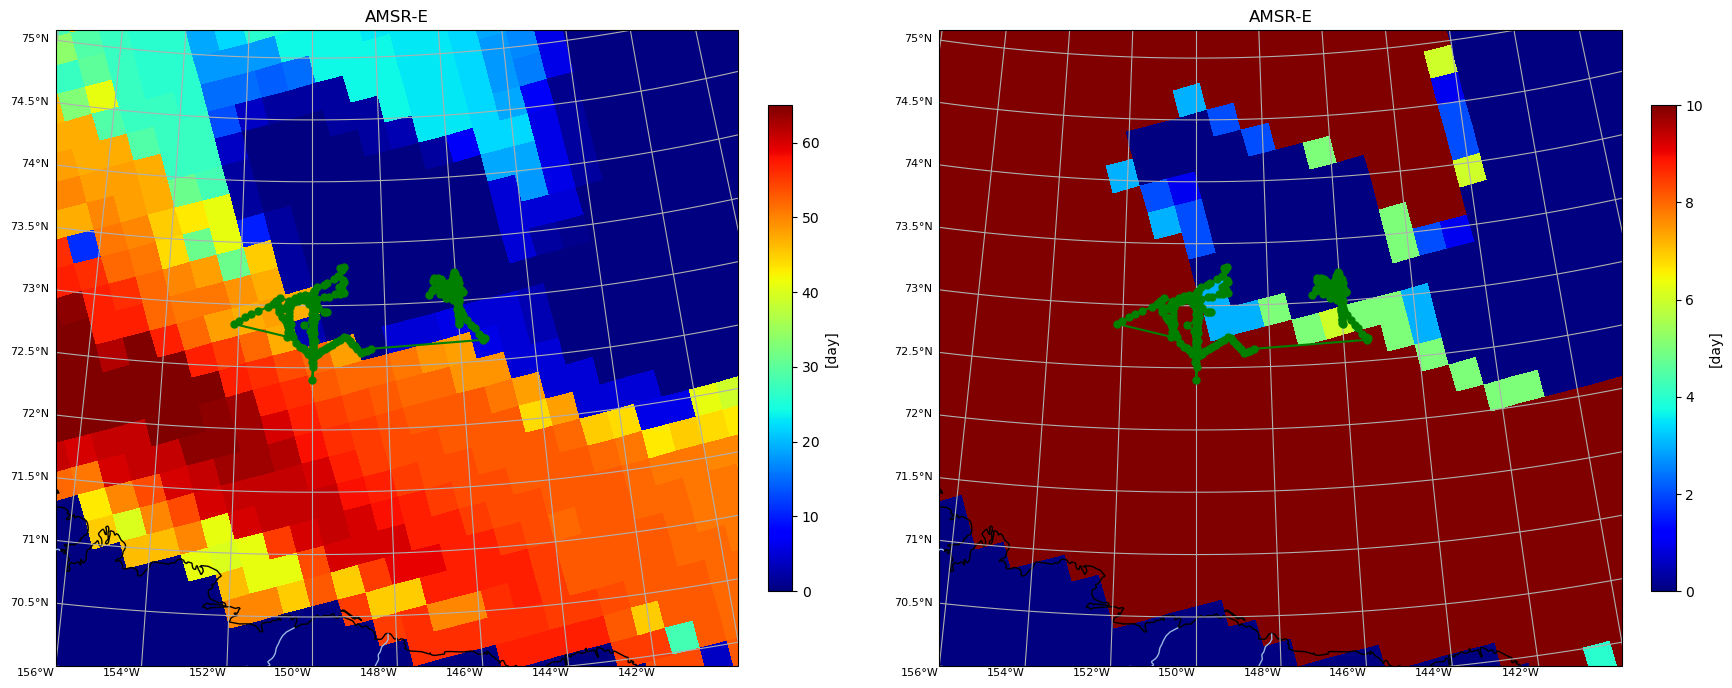

In [25]:
# Figure
fig = plt.figure(figsize=[18, 10])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.NorthPolarStereo(central_longitude=lon0))

make_fancy(ax1)
ax1.set_title('AMSR-E')
#----------------------------------------------------------------------------#
cb = ax1.pcolormesh(ice_cdf_x,ice_cdf_y,first_ice,transform=crs_iced,
                    cmap='jet', zorder=1, vmin=0,vmax=65)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[day]", orientation="vertical",shrink=0.75)
ax1.plot(ctd_lon, ctd_lat, transform=ccrs.PlateCarree(), zorder=4,marker='.', markersize=10,color='g')
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.NorthPolarStereo(central_longitude=lon0))

make_fancy(ax1)
ax1.set_title('AMSR-E')
#----------------------------------------------------------------------------#
cb = ax1.pcolormesh(ice_cdf_x,ice_cdf_y,first_ice_30p,transform=crs_iced,
                    cmap='jet', zorder=1, vmin=0,vmax=10)#,norm=norm
cbar = plt.colorbar(cb,fraction=0.033, pad=0.04,
                   label="[day]", orientation="vertical",shrink=0.75)
ax1.plot(ctd_lon, ctd_lat, transform=ccrs.PlateCarree(), zorder=4,marker='.', markersize=10,color='g')

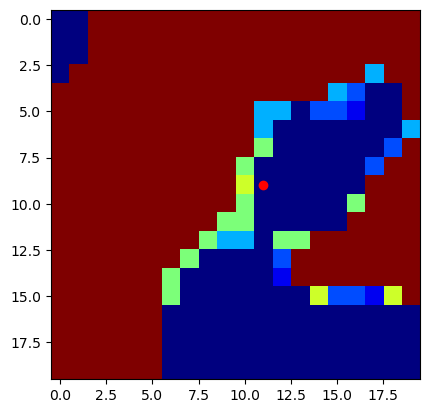

In [26]:
plt.imshow(first_ice_30p[210:230,70:90], cmap='jet',vmin=0,vmax=10);plt.plot(11,9, 'ro')

In [27]:
ptrow=210+9;ptcol=70+10+1;

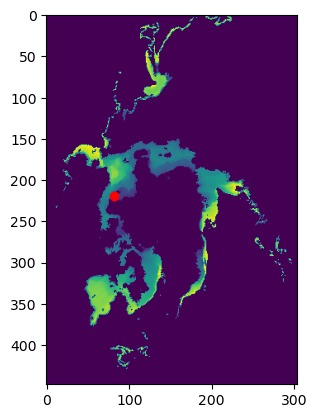

In [28]:
plt.imshow(first_ice_30p);plt.plot(ptcol, ptrow, 'ro')

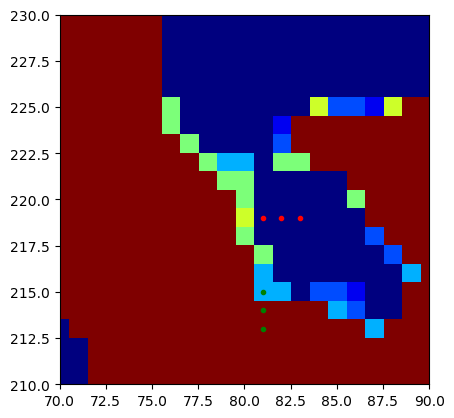

In [29]:
plt.imshow(first_ice_30p,vmin=0,vmax=10,cmap='jet',origin='upper');
#plt.plot(ptcol, ptrow, 'r.')
#plt.plot(ptcol-1,ptrow,'r.')
plt.plot(ptcol+0,ptrow,'r.')
plt.plot(ptcol+1,ptrow,'r.')
plt.plot(ptcol+2,ptrow,'r.')

plt.xlim([70,90]);plt.ylim([210,230])

ptcol2 = ptcol
ptrow2 = ptrow-4
plt.plot(ptcol2, ptrow2, 'g.')
plt.plot(ptcol2, ptrow2-1,'g.')
plt.plot(ptcol2, ptrow2-2,'g.')


(42.0, 60.0)

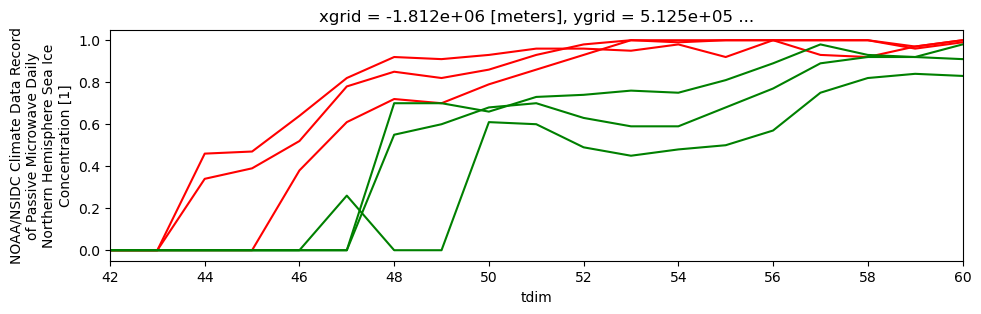

In [30]:
plt.figure(figsize=[11,3]);
ice_cdf[:, ptrow, ptcol].plot(color='r')
ice_cdf[:, ptrow, ptcol+1].plot(color='r')
ice_cdf[:, ptrow, ptcol+2].plot(color='r')

ice_cdf[:, ptrow2, ptcol2].plot(color='g')
ice_cdf[:, ptrow2-1, ptcol2].plot(color='g')
ice_cdf[:, ptrow2-2, ptcol2].plot(color='g')

plt.xlim([42,60])